In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
import sys
print(sys.version) 
print(sys.version_info)

3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]
sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


In [3]:
testing_data = '../data/testing.csv'
training_data = '../data/training.csv'
validation_data = '../data/validation.csv'

# Create dataframes train and test
train = pd.read_csv(training_data)
test = pd.read_csv(validation_data)
train

,recordId,drugName,condition,reviewComment,date,usefulCount,sideEffects,rating
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...","February 28, 2012",22,Mild Side Effects,5
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...","May 17, 2009",17,Severe Side Effects,4
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""","September 29, 2017",3,No Side Effects,5
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...","March 5, 2017",35,Mild Side Effects,5
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...","October 22, 2015",4,Severe Side Effects,5
...,...,...,...,...,...,...,...,...
6994,21322,Rivastigmine,Alzheimer's Disease,"""I have 7 Immediate Family members that had Al...","February 2, 2016",11,Mild Side Effects,5
6995,172273,Clonazepam,Periodic Limb Movement Disorde,"""Started on 0.5 mg at bedtime for possible res...","May 20, 2017",0,No Side Effects,4
6996,29177,Topiramate,Obesity,"""I am on day 4 now and I am pretty spacey. I ...","December 18, 2016",79,Mild Side Effects,5
6997,197612,Suprep Bowel Prep Kit,Bowel Preparation,"""I could only complete the first session. With...","December 9, 2017",1,No Side Effects,1


In [4]:
test.head()

,recordId,drugName,condition,reviewComment,date,usefulCount,sideEffects,rating
0,107140,Implanon,Birth Control,"""Getting it taken out after 6 months of non-st...","December 15, 2012",3,Mild Side Effects,1
1,117878,Simponi,Ankylosing Spondylitis,"""Had 1st shot of Simponi and didn&#039;t notic...","December 11, 2016",3,Severe Side Effects,1
2,169125,Vilazodone,Depression,"""Awesome. Best medicine I&#039;ve ever found f...","August 13, 2011",406,Mild Side Effects,5
3,232011,Trazodone,ibromyalgia,"""Can&#039;t recommend more highly. Unless my ...","April 12, 2010",39,Moderate Side Effects,5
4,128852,Phentermine,Weight Loss,"""I need to lose 30 lbs. I tried every thing, e...","August 3, 2014",58,No Side Effects,5


In [5]:
list(train) == list(test)

True

In [6]:
list(train)

['recordId',
 'drugName',
 'condition',
 'reviewComment',
 'date',
 'usefulCount',
 'sideEffects',
 'rating']

In [7]:
train.values.shape[0], test.values.shape[0], train.values.shape[0] / test.values.shape[0]

(6999, 1199, 5.837364470391993)

In [8]:
train.condition.unique().size, test.condition.unique().size

(409, 208)

In [9]:
train.drugName.unique().size, test.drugName.unique().size

(1300, 534)

In [10]:
conditions = train.condition.value_counts().sort_values(ascending=False)
conditions[:10]

Birth Control      1265
Depression          427
Pain                270
Anxiety             248
Acne                234
Bipolar Disorde     186
Weight Loss         182
Insomnia            154
ADHD                139
Obesity             130
Name: condition, dtype: int64

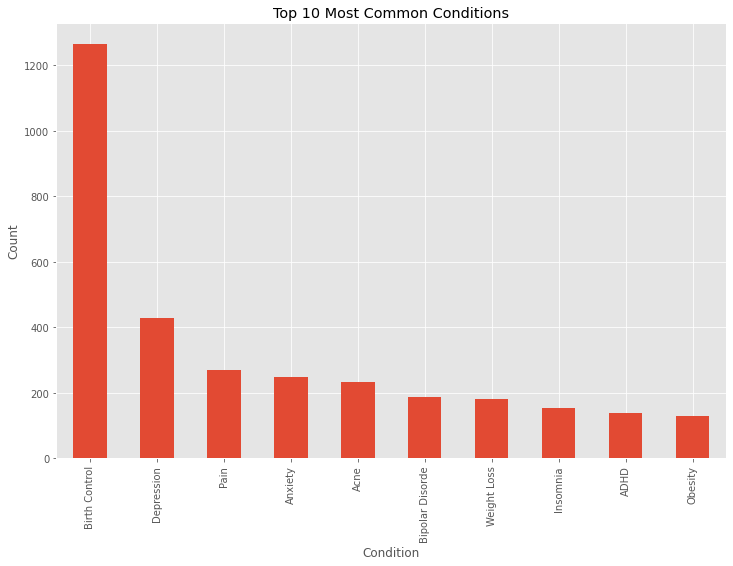

In [11]:
plt.rcParams['figure.figsize'] = [12, 8]
conditions[:10].plot(kind='bar')
plt.title('Top 10 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');

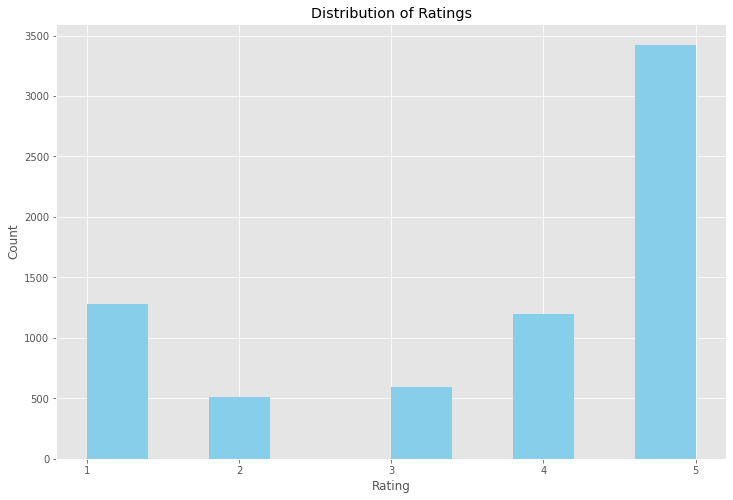

In [12]:
### Rating Distribution
# Look at bias in review (also shown on 'Data' page in competition: distribution of ratings)
train.rating.hist(color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 6)]);

Text(0, 0.5, 'Count')

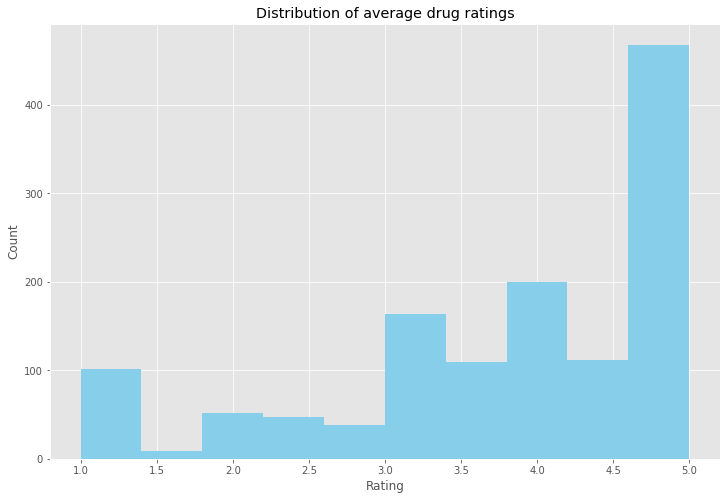

In [13]:
# Distribution of average drug ratings
rating_avgs = (train['rating'].groupby(train['drugName']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Distribution of average drug ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

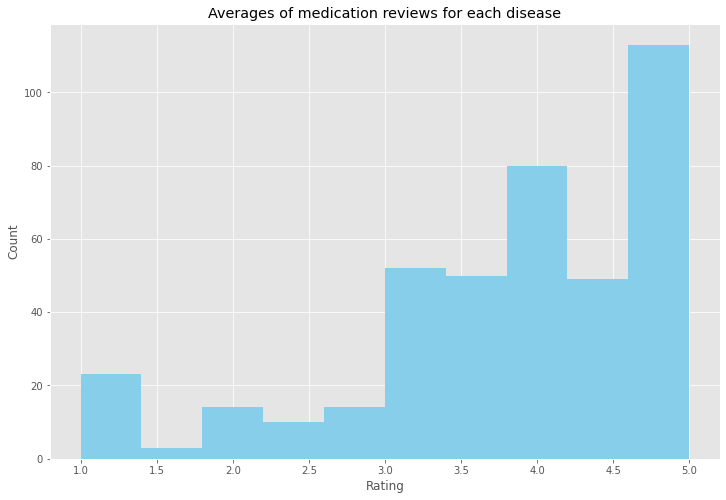

In [14]:
# Averages of medication reviews for each disease
rating_avgs = (train['rating'].groupby(train['condition']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Averages of medication reviews for each disease')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

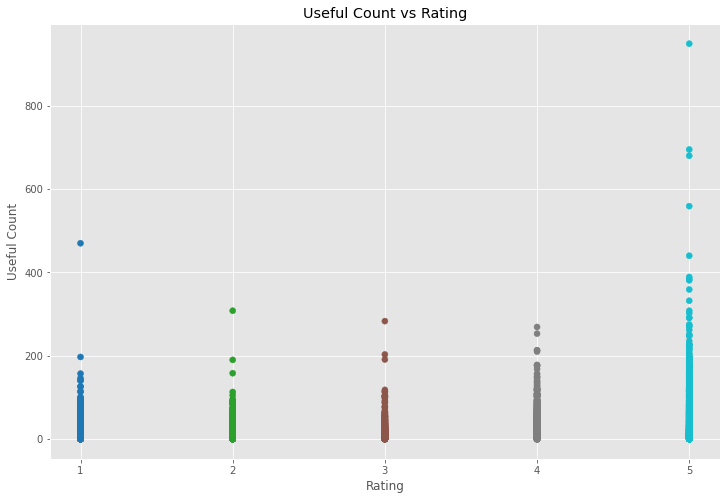

In [15]:
# Is rating correlated with usefulness of the review?
plt.scatter(train.rating, train.usefulCount, c=train.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1, 6)]);

In [16]:
# Create a list (cast into an array) containing the average usefulness for given ratings
use_ls = []

for i in range(1, 11):
    use_ls.append([i, np.sum(train[train.rating == i].usefulCount) / np.sum([train.rating == i])])
    
use_arr = np.asarray(use_ls)

/tmp/ipykernel_1094665/1048109315.py:5: RuntimeWarning: invalid value encountered in long_scalars
  use_ls.append([i, np.sum(train[train.rating == i].usefulCount) / np.sum([train.rating == i])])


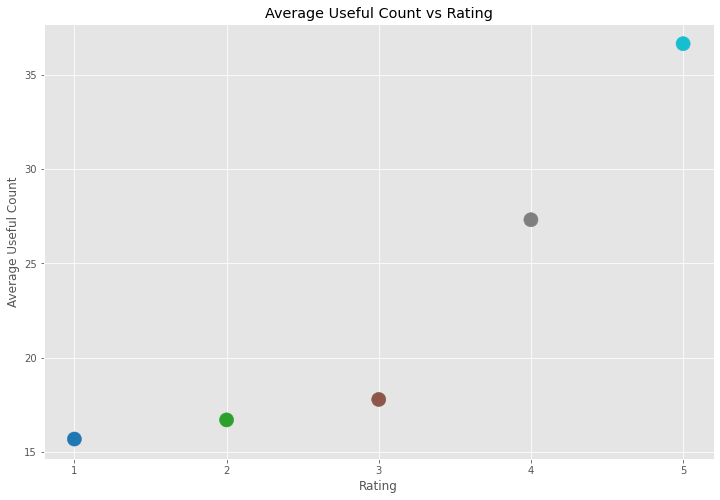

In [17]:
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 6)]);

In [18]:
# Sort train dataframe from most to least useful
useful_train = train.sort_values(by='usefulCount', ascending=False)
useful_train.iloc[:10]

,recordId,drugName,condition,reviewComment,date,usefulCount,sideEffects,rating
3829,96615,Sertraline,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...","August 5, 2008",949,Moderate Side Effects,5
5099,151366,OxyContin,Pain,"""Ahhhh, the dreaded drug...no matter what you ...","April 15, 2008",695,Mild Side Effects,5
3014,96501,Sertraline,Depression,"""I am 55 years old and have been taking Zoloft...","January 18, 2009",680,Severe Side Effects,5
6311,62640,Citalopram,Depression,"""I&#039;ve been taking Celexa for about 2 mont...","January 29, 2010",559,Moderate Side Effects,5
283,130982,Levonorgestrel,Birth Control,"""I have had this for about 5 months now.. I ha...","May 7, 2010",470,Moderate Side Effects,1
6547,201567,Zoloft,Depression,"""I was suffering from being a slave to my nega...","April 21, 2014",440,Moderate Side Effects,5
3413,171527,Wellbutrin,Depression,"""I am a 35 year old woman, who has taken meds ...","January 17, 2015",389,Extremely Severe Side Effects,5
1010,197453,Paroxetine,Depression,"""In the sea of negative reviews which I read b...","February 22, 2010",384,Moderate Side Effects,5
700,119135,Zoloft,Depression,"""I was crying over the weirdest things and did...","May 9, 2009",381,Moderate Side Effects,5
4971,181734,Prozac,Anxiety and Stress,"""I started taking Prozac (10mg) a couple of mo...","November 26, 2009",359,Mild Side Effects,5


In [19]:
# Print top 3 most useful reviews
for i in useful_train.reviewComment.iloc[:3]:
    print(i, '\n')

"I&#039;ve been on Zoloft 50mg for over two years. I am a more relaxed and easy-going person because of Zoloft.  Prior to starting the medicine, I was anxious all the time, worried constantly about everything, and suffered periods of depression and hopelessness.  Now I am a better wife, friend, and person in general." 



My story:  Two brain surgeries.  Manmouth amounts of pain.  I tried everything -- nothing lasted like this drug.  It has allowed me to go back to work, to live my life, to be a father to my children.  Screw the strange looks @the pharmacy...I&#039;m alive!" 

"I am 55 years old and have been taking Zoloft over 20 years. For me it has been a miracle medicine. I find I am much more on an even keel and while some things still upset me, it&#039;s far less than without Zoloft. I find too I am much more rational in my thought processes and am more confident of choices I make. I have several medical conditions that contribute to feeling depressed, overwhelmed, and yes, even 

In [20]:
# Print 3 of the least useful reviews
for i in useful_train.reviewComment.iloc[-3:]:
    print(i, '\n')

"I had the Paragard IUD for 6 months, I chose this particular birth control because it has no horomones! My experience getting the device inserted was smooth.. it didn&#039;t hurt at all, but there was indeed some pressure! I was sore for about 3 days, my periods stayed the same, and everything was normal.. the only thing I would point on though was I kept having a strong cramp in my tail bone and sex was quite uncomfortable! Other then that this birth control gave me no other problems." 

"I took this for one week. It gave me terrible acne. I have never had acne more than an occasional pimple, but it made my face red and bumpy all over, and it has stayed ever since! I switched to a mini pill for a few months and then stopped birth control to get pregnant. It has been 8 months since then and I still have a red bumpy face." 

"Nuvaring has regulated my cycle, practically diminished any menstrual cramps, and given me peace of mind, which is most important to me. It&#039;s hard to mess th

In [21]:
sid = SentimentIntensityAnalyzer()
# Create list (cast to array) of compound polarity sentiment scores for reviews
sentiments = []

for i in train.reviewComment:
    sentiments.append(sid.polarity_scores(i).get('compound'))
    
sentiments = np.asarray(sentiments)

In [22]:
sentiments

array([-0.4596,  0.0736,  0.    , ...,  0.789 , -0.8016, -0.8431])

In [23]:
useful_train['sentiment'] = pd.Series(data=sentiments)

In [24]:
useful_train = useful_train.reset_index(drop=True)
useful_train.head()

,recordId,drugName,condition,reviewComment,date,usefulCount,sideEffects,rating,sentiment
0,96615,Sertraline,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...","August 5, 2008",949,Moderate Side Effects,5,-0.6815
1,151366,OxyContin,Pain,"""Ahhhh, the dreaded drug...no matter what you ...","April 15, 2008",695,Mild Side Effects,5,-0.8096
2,96501,Sertraline,Depression,"""I am 55 years old and have been taking Zoloft...","January 18, 2009",680,Severe Side Effects,5,-0.7275
3,62640,Citalopram,Depression,"""I&#039;ve been taking Celexa for about 2 mont...","January 29, 2010",559,Moderate Side Effects,5,0.9399
4,130982,Levonorgestrel,Birth Control,"""I have had this for about 5 months now.. I ha...","May 7, 2010",470,Moderate Side Effects,1,-0.7661


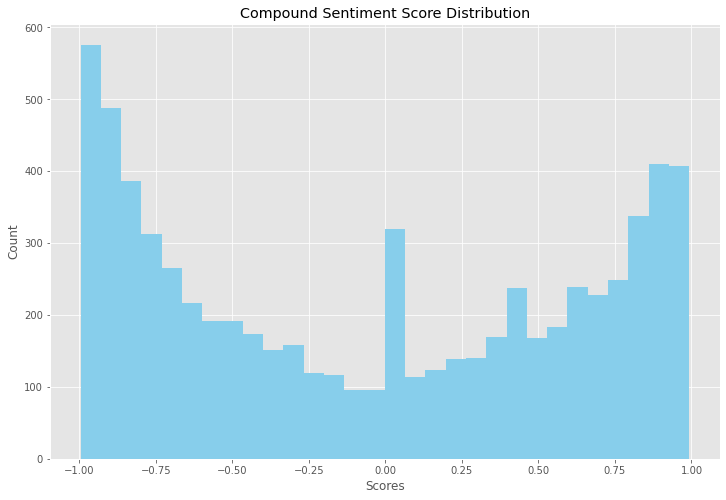

In [25]:
useful_train.sentiment.hist(color='skyblue', bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count');

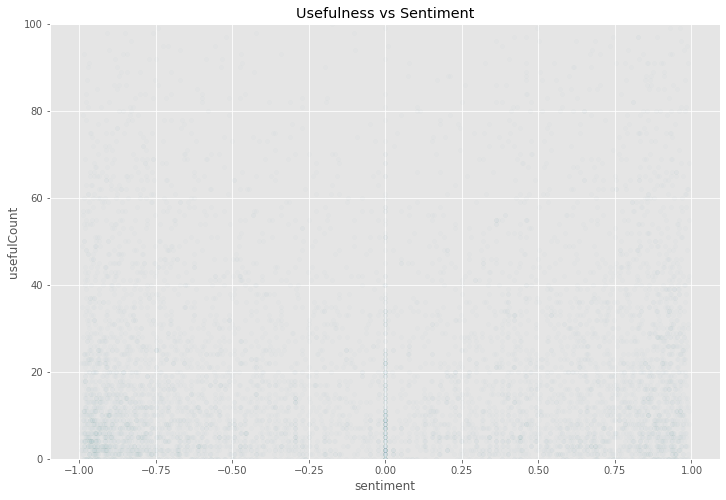

In [26]:
useful_train.plot(x='sentiment', y='usefulCount', kind='scatter', alpha=0.01)
plt.title('Usefulness vs Sentiment')
plt.ylim(0, 100);

In [27]:
temp_ls = []

for i in range(1, 11):
    temp_ls.append(np.sum(useful_train[useful_train.rating == i].sentiment) / np.sum(useful_train.rating == i))

/tmp/ipykernel_1094665/416415530.py:4: RuntimeWarning: invalid value encountered in double_scalars
  temp_ls.append(np.sum(useful_train[useful_train.rating == i].sentiment) / np.sum(useful_train.rating == i))


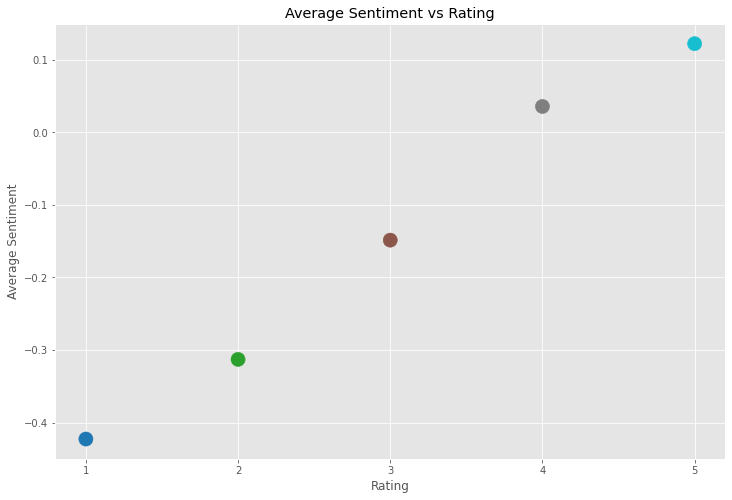

In [28]:
plt.scatter(x=range(1, 11), y=temp_ls, c=range(1, 11), cmap='tab10', s=200)
plt.title('Average Sentiment vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment')
plt.xticks([i for i in range(1, 6)]);

In [29]:
# Create a list of all drugs and their average ratings, cast to dataframe
rate_ls = []

for i in train.drugName.unique():
    
    # Only consider drugs that have at least 10 ratings
    if np.sum(train.drugName == i) >= 10:
        rate_ls.append((i, np.sum(train[train.drugName == i].rating) / np.sum(train.drugName == i)))
    
avg_rate = pd.DataFrame(rate_ls)

In [30]:
# Sort drugs by their ratings, look at top 10 best and worst rated drugs
avg_rate = avg_rate.sort_values(by=[1], ascending=False).reset_index(drop=True)
avg_rate[:10]

,0,1
0,Spironolactone,5.000000
1,Xanax,4.875000
2,Hydromorphone,4.833333
3,Suboxone,4.818182
4,Qsymia,4.700000
5,Tretinoin,4.700000
6,Benzoyl peroxide / clindamycin,4.666667
7,Acetaminophen / butalbital / caffeine,4.636364
8,Sumatriptan,4.600000
9,Plan B,4.590909


In [31]:
avg_rate[-10:]

,0,1
156,Ethinyl estradiol / norethindrone,2.637255
157,Lisinopril,2.636364
158,Macrobid,2.600000
159,Synthroid,2.500000
160,Seasonique,2.500000
161,Norethindrone,2.416667
162,Strattera,2.357143
163,Benzonatate,2.266667
164,Monistat 3-Day Combination Pack,1.900000
165,Miconazole,1.863636


In [32]:
### Best and Worst Drugs by Condition
# Make dictionary of conditions, each value will be a dataframe of all of the drugs used to treat the given condition
help_dict = {}

# Iterate over conditions
for i in train.condition.unique():
    
    temp_ls = []
    
    # Iterate over drugs within a given condition
    for j in train[train.condition == i].drugName.unique():
        
        # If there are at least 10 reviews for a drug, save its name and average rating in temporary list
        if np.sum(train.drugName == j) >= 10:
            temp_ls.append((j, np.sum(train[train.drugName == j].rating) / np.sum(train.drugName == j)))
        
    # Save temporary list as a dataframe as a value in help dictionary, sorted best to worst drugs
    help_dict[i] = pd.DataFrame(data=temp_ls, columns=['drug', 'average_rating']).sort_values(by='average_rating', ascending=False).reset_index(drop=True)

In [33]:
help_dict['Birth Control'].iloc[:10]

,drug,average_rating
0,Liletta,4.181818
1,Implanon,4.055556
2,Ethinyl estradiol / norelgestromin,4.000000
3,ParaGard,3.909091
4,Desogestrel / ethinyl estradiol,3.857143
5,Skyla,3.842105
6,Levonorgestrel,3.718391
7,Yaz,3.700000
8,Ethinyl estradiol / etonogestrel,3.590909
9,NuvaRing,3.500000


In [34]:
help_dict['Depression'].iloc[:10]

,drug,average_rating
0,Xanax,4.875000
1,Lexapro,4.516129
2,Wellbutrin XL,4.500000
3,Alprazolam,4.407407
4,Paxil,4.384615
5,Nuvigil,4.333333
6,Tramadol,4.183673
7,Bupropion,4.181818
8,Fluoxetine,4.157895
9,Risperidone,4.090909


In [35]:
help_dict['Acne'].iloc[:10]

,drug,average_rating
0,Spironolactone,5.000000
1,Tretinoin,4.700000
2,Benzoyl peroxide / clindamycin,4.666667
3,Isotretinoin,4.428571
4,Adapalene / benzoyl peroxide,3.842105
5,Yaz,3.700000
6,Minocycline,3.666667
7,Doxycycline,3.645161
8,Bactrim,3.562500
9,Drospirenone / ethinyl estradiol,3.500000


In [36]:
help_dict['Acne'].iloc[-10:]

,drug,average_rating
9,Drospirenone / ethinyl estradiol,3.500000
10,Microgestin Fe 1 / 20,3.454545
11,Tri-Sprintec,3.409091
12,Clindamycin,3.400000
13,Junel Fe 1 / 20,3.333333
14,Sulfamethoxazole / trimethoprim,3.281250
15,Ethinyl estradiol / norgestimate,3.000000
16,TriNessa,2.750000
17,Loestrin 24 Fe,2.666667
18,Ethinyl estradiol / norethindrone,2.637255


# Classification with sk-learn and Random Forests

In [37]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train.reviewComment)

# transforms test reviews to above vectorized format
X_test = vectorizer.transform(test.reviewComment)

In [40]:
# Create a column with binary rating indicating the polarity of a review
train['binary_rating'] = train['rating']

y_train_rating = train.binary_rating
clf = MultinomialNB().fit(X_train, y_train_rating)

# Evaluates model on test set
test['binary_rating'] = test.rating
y_test_rating = test.binary_rating
pred = clf.predict(X_test)

print("Accuracy: %s" % str(clf.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Accuracy: 0.49791492910758967
Confusion Matrix
[[  2   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [224  83 103 192 595]]


In [64]:
pd.value_counts(y_train_rating)

5    3425
1    1276
4    1196
3     592
2     510
Name: binary_rating, dtype: int64

In [42]:
# Trains random forest classifier
start = time.time()
rfc_rating = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 1000, min_samples_split = 0.001)
rfc_rating.fit(X_train, y_train_rating)
end = time.time()
print("Training time: %s" % str(end-start))

# Evaluates model on test set
pred = rfc_rating.predict(X_test)


print("Accuracy: %s" % str(rfc_rating.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Training time: 15.745510339736938
Accuracy: 0.5371142618849041
Confusion Matrix
[[ 44   7   2   0   1]
 [  0   3   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   4   1]
 [181  73 101 188 593]]


In [48]:
print(X_test[0])

  (0, 1147)	0.1242212596540581
  (0, 1350)	0.2903632174065533
  (0, 2164)	0.22378340478694336
  (0, 2198)	0.23221038024905605
  (0, 2243)	0.2116295739316452
  (0, 4128)	0.16432617424179322
  (0, 5302)	0.15304931982746567
  (0, 5869)	0.19660967650930805
  (0, 6231)	0.08760614310092998
  (0, 7189)	0.07206229265941659
  (0, 7317)	0.14616756688039087
  (0, 7680)	0.14332279184492816
  (0, 7844)	0.21048444757570176
  (0, 8467)	0.143398837478782
  (0, 8574)	0.07338843160845566
  (0, 8802)	0.29088947125944886
  (0, 8841)	0.11048556851912679
  (0, 9000)	0.17150599566578245
  (0, 9170)	0.14845212982686878
  (0, 12204)	0.21453140724228442
  (0, 12335)	0.47455909128925755
  (0, 12618)	0.2139925028637383
  (0, 13991)	0.1776816915577272
  (0, 14100)	0.10115546499794754
  (0, 14147)	0.17395072049732443


# Classification with Keras¶

In [65]:
b = "'@#$%^()&*;!.-"
X_train = np.array(train['reviewComment'])
X_test = np.array(test['reviewComment'])

def clean(X):
    for index, review in enumerate(X):
        for char in b:
            X[index] = X[index].replace(char, "")
    return(X)

X_train = clean(X_train)
X_test = clean(X_test)
print(X_train[:2])

['"I039ve tried a few antidepressants over the years citalopram, fluoxetine, amitriptyline, but none of those helped with my depression, insomnia amp anxiety My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life Thankfully I have had no side effects especially the most common  weight gain, I039ve actually lost alot of weight I still have suicidal thoughts but mirtazapine has saved me"'
 '"My son has Crohn039s disease and has done very well on the Asacol  He has no complaints and shows no side effects  He has taken as many as nine tablets per day at one time  I039ve been very happy with the results, reducing his bouts of diarrhea drastically"']


In [68]:
# Doing some preprocessing by removing all symbols from the reviews.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from tensorflow.keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk

vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),lowercase=True, max_features=5000)
#vectorizer = TfidfVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, max_features=5000)
test_train = np.concatenate([X_train, X_test])
print(test_train.shape)
X_onehot = vectorizer.fit_transform(test_train)
stop_words = vectorizer.get_stop_words()
print(type(X_onehot))

(8198,)
<class 'scipy.sparse._csr.csr_matrix'>


In [69]:
print(X_onehot.shape)
print(X_onehot.toarray())

(8198, 5000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [76]:
names_list = vectorizer.get_feature_names()
names = [[i] for i in names_list]
names = Word2Vec(names, min_count=1)
print(len(list(names.wv.vocab)))
print(list(names.wv.vocab)[:5])

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [71]:
def score_transform(X):
    y_reshaped = np.reshape(X['rating'].values, (-1, 1))
    for index, val in enumerate(y_reshaped):
        y_reshaped[index] = val

    y_result = to_categorical(y_reshaped)
    return y_result
    
    print(X_onehot)

In [72]:
y_train_test = pd.concat([train, test], ignore_index=True)
y_train = score_transform(y_train_test)
print(y_train)
print(y_train.shape)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
(8198, 6)


In [73]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [74]:
import tensorflow.python.keras.backend as K 
sess = K.get_session()

2022-03-24 13:59:42.767220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-24 13:59:42.767275: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-24 13:59:42.767302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (VM-20-12-ubuntu): /proc/driver/nvidia/version does not exist
2022-03-24 13:59:42.773564: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [75]:
from numpy.random import seed

np.random.seed(1)
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names())))
model.add(Dense(units=3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary


# I experimented a lot with different kinds of simple NN architecture and this is what I concluded:
# 
# Softmax was the best activation function for the output layer.
# Vectorizing with the TFIDF vectorizer took longer to converge but had roughly the same accuracy as when I vectorized with the CountVectorizer. Changing binary and lowercase didn't result in any changes.
# 256 units was the sweet spot for accuracy without overfitting.
# Any units above would give me less accuracy as the model continued to train as well as overall performing worse, and less units just gave me worse accuracy overall.
# I also discovered that adding any additional layers to the model resulted in a loss of accuracy, even when I kept the number of layer units small.

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f149a9a4040>>

In [77]:
history = model.fit(X_onehot[:-5000], y_train[:-5000], epochs=6, batch_size=128, verbose=1, validation_data=(X_onehot[3000:6000], y_train[3000:6000]))

2022-03-24 14:01:05.766005: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at serialize_sparse_op.cc:389 : INVALID_ARGUMENT: indices[2] = [0,465] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.




InvalidArgumentError: indices[2] = [0,465] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]